In [168]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree



# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder



from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from tqdm import tqdm


# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [169]:
from src import soporte_ajuste as sa

In [170]:
df = pd.read_csv("datos/datos_preprocesados.csv",index_col=0)

In [171]:
df.head()

,price,size,municipality,distance,hasVideo,status,hasPlan,has3DTour,floor,hasLift,...,rooms_3,rooms_4,bathrooms_1,bathrooms_2,bathrooms_3,showAddress_False,showAddress_True,has360_False,has360_True,has360_desconocido
0,750.0,0.12,0.445948,-0.252799,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
1,750.0,0.52,0.038221,0.182949,1.0,0.0,1.0,0.0,-0.756628,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,715.0,0.00,0.038221,-0.020333,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,590.0,0.52,-2.098184,2.118218,0.0,0.0,0.0,0.0,-1.114680,0.0,...,1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,715.0,0.00,0.038221,-0.020333,0.0,0.0,0.0,0.0,0.069359,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
# Separamos la variable respuesta del resto de variables
X = df.drop(columns="price")
y = df[["price"]]

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)


In [174]:
np.set_printoptions(suppress= True)
# Establecemos un diccionario con los hiperparámetros
params_arbol = {
    'max_depth': [2, 3, 4, 5,],
    'min_samples_split': [1, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_leaf_nodes': [5, 6, 7, 8, 9]
}

In [175]:
grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, 
                                 scoring = "neg_mean_squared_error", 
                                 n_jobs = -1) 
grid_search_arbol.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_leaf_nodes': [5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 3, 4, 5]},
             scoring='neg_mean_squared_error')

In [176]:
modelo_final_arbol = grid_search_arbol.best_estimator_
modelo_final_arbol

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=8, min_samples_leaf=3)

In [177]:
y_pred_test = modelo_final_arbol.predict(X_test)
y_pred_train = modelo_final_arbol.predict(X_train)

In [178]:
df_metricas_arbol = sa.metricas(y_train, y_pred_train, y_test, y_pred_test)
df_metricas_arbol

,r2_score,MAE,MSE,RMSE
train,0.516743,27.956012,1380.188728,37.150891
test,0.500628,31.147467,1603.465126,40.043291


El modelo no es bueno, y si bajamos el tamaño de train_test obtenemos metricas peores, y overfitting. Estás metricas son algo peores que las que obtuvimos con regressión lineal.

Comparamos los precios predichos con los precios de los datos originales.

In [179]:
y_train.reset_index(inplace= True)
df_predicted = pd.DataFrame(y_pred_train)
df_predicted.rename(columns = {0:"predicted"}, inplace=True)
df_precios = pd.concat([df_predicted, y_train], axis=1)
df_precios.drop(columns = "index", inplace= True)
df_precios.head(5)

,predicted,price
0,698.088235,750.0
1,719.260417,600.0
2,719.260417,700.0
3,719.260417,720.0
4,719.260417,715.0


Vamos a ver la importancia de cada variable y tal vez saquemos alguna conclusión para futuras mejoras del modelo

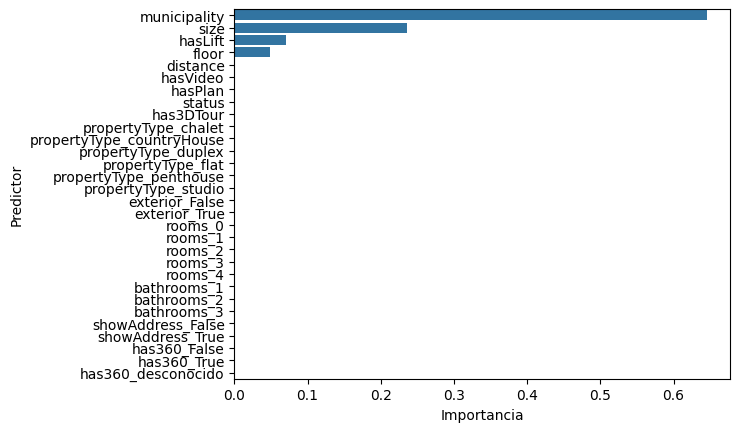

In [180]:
importancias = modelo_final_arbol.feature_importances_
importancia_rf = pd.DataFrame({"Predictor": X_train.columns, "Importancia": importancias})
importancia_rf = importancia_rf.sort_values(by="Importancia", ascending=False)
sns.barplot(y = "Predictor", x = "Importancia", data = importancia_rf);

Tenemos muchas variables con importancia nula que eliminaremos en proximos modelos.